In [12]:
import os
import numpy as np
import pyvista as pv
import nibabel
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

from pathlib import Path

import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

import polpo.preprocessing.pd as ppd
from polpo.models import ObjectRegressor
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.dict import DictMap, DictMerger
from polpo.preprocessing.load.pregnancy import (
    DenseMaternalCsvDataLoader,
    DenseMaternalMeshLoader,
)
from polpo.preprocessing.mesh.conversion import ToVertices
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline
from polpo.sklearn.mesh import BiMeshesToVertices
from polpo.sklearn.np import BiFlattenButFirst, FlattenButFirst

structure_key = {
    10: "Left-Thalamus-Proper",
    11: "Left-Caudate",
    12: "Left-Putamen",
    13: "Left-Pallidum",
    17: "Left-Hippocampus",
    18: "Left-Amygdala",
    26: "Left-Accumbens-area",
    49: "Right-Thalamus-Proper",
    50: "Right-Caudate",
    51: "Right-Putamen",
    52: "Right-Pallidum",
    53: "Right-Hippocampus",
    54: "Right-Amygdala",
    58: "Right-Accumbens-area"
}

shapes_dir = '/Users/sak/.herbrain/data/engima/derivatives/enigma_shape_hires_long/'

# Function to convert nibabel mesh to PyVista PolyData
def nibabel_to_pyvista(mesh):
    V = mesh[0]
    F = mesh[1]
    face_data = np.hstack(np.c_[np.full(len(F), 3), F]).astype(np.int64)
    return pv.PolyData(V, face_data)

# Load X data once
df = pd.read_csv("/Users/sak/.herbrain/data/maternal/28Baby_Hormones.csv")
X = df["gestWeek"]

# Shared transformation pipeline
dataset_pipe = DictMerger() + NestingSwapper() + IndexMap(lambda x: np.array(x)[:, None], index=0)
X

0      -3.0
1      -0.5
2       1.0
3       1.5
4       2.0
5       3.0
6       9.0
7      12.0
8      14.0
9      15.0
10     17.0
11     19.0
12     22.0
13     24.0
14     27.0
15     29.0
16     31.0
17     33.0
18     36.0
19     43.0
20     46.0
21     49.0
22     51.0
23     68.0
24     93.0
25    162.0
26    162.0
Name: gestWeek, dtype: float64

In [13]:
from scipy.stats import f, combine_pvalues
from scipy import stats
from statsmodels.stats.multitest import multipletests

model_configs = [
    ("linear", None),
    ("spline", 1),  # linear spline
    ("spline", 2),  # quadratic spline
    ("spline", 3),  # cubic spline
    ("spline", 4),  # cubic spline
]


In [14]:
all_meshes = {}
for structure_id, structure_name in structure_key.items():
        print(f"\n=== Processing {structure_name} ({structure_id}) ===")
        brain_structure_filename = f"resliced_mesh_{structure_id}"
        mesh_paths = []

        for subdir in sorted(os.listdir(shapes_dir)):
            full_path = os.path.join(shapes_dir, subdir, brain_structure_filename)
            if os.path.exists(full_path):
                mesh_paths.append((subdir, full_path))

        aligned_meshes = {}
        reference_mesh = None

        for i_mesh, (name, path) in enumerate(mesh_paths):
            mesh = nibabel.freesurfer.read_geometry(path)
            pv_mesh = nibabel_to_pyvista(mesh)  # <- You must define this
            if i_mesh == 0:
                reference_mesh = pv_mesh
                aligned_meshes[i_mesh] = pv_mesh
            else:
                aligned = pv_mesh.align(
                    reference_mesh,
                    max_landmarks=100,
                    max_mean_distance=1e-5,
                    max_iterations=500,
                    check_mean_distance=True,
                    start_by_matching_centroids=True,
                )
                aligned_meshes[i_mesh] = aligned
        all_meshes[structure_id] = aligned_meshes


=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Processing Right-Pallidum (52) ===

=== Processing Right-Hippocampus (53) ===

=== Processing Right-Amygdala (54) ===

=== Processing Right-Accumbens-area (58) ===


In [15]:
def run_full_regression_analysis(structure_key, shapes_dir, X_base, dataset_pipe):
    model_dfs = {}

    for model_type, spline_degree in model_configs:
        model_key = f"{model_type}" if model_type == "linear" else f"{model_type}_d{spline_degree}"
        rows = []

        for structure_id, structure_name in structure_key.items():
            print(f"\n=== Processing {structure_name} ({structure_id}) ===")
            brain_structure_filename = f"resliced_mesh_{structure_id}"
            mesh_paths = []

            for subdir in sorted(os.listdir(shapes_dir)):
                full_path = os.path.join(shapes_dir, subdir, brain_structure_filename)
                if os.path.exists(full_path):
                    mesh_paths.append((subdir, full_path))

            aligned_meshes = {}
            reference_mesh = None

            for i_mesh, (name, path) in enumerate(mesh_paths):
                mesh = nibabel.freesurfer.read_geometry(path)
                pv_mesh = nibabel_to_pyvista(mesh)  # <- You must define this
                if i_mesh == 0:
                    reference_mesh = pv_mesh
                    aligned_meshes[i_mesh] = pv_mesh
                else:
                    aligned = pv_mesh.align(
                        reference_mesh,
                        max_landmarks=100,
                        max_mean_distance=1e-5,
                        max_iterations=500,
                        check_mean_distance=True,
                        start_by_matching_centroids=True,
                    )
                    aligned_meshes[i_mesh] = aligned

            # Target preprocessing: mesh → 4 PCA components
            pca = PCA(n_components=4)
            objs2y = AdapterPipeline([
                BiMeshesToVertices(index=0),
                FunctionTransformer(func=np.stack),
                BiFlattenButFirst(),
                StandardScaler(with_std=False),
                pca,
            ])

            X, meshes_ = dataset_pipe((X_base, aligned_meshes))

            if model_type == 'linear':
                model = ObjectRegressor(LinearRegression(), objs2y=objs2y)
            elif model_type == 'spline':
                spline_model = make_pipeline(
                    SplineTransformer(n_knots=4, degree=spline_degree, include_bias=False),
                    LinearRegression(fit_intercept=True)
                )
                model = ObjectRegressor(spline_model, objs2y=objs2y)


            model.fit(X, meshes_)
            y_true = objs2y.transform(meshes_)
            y_pred = objs2y.transform(model.predict(X))

            if model_type == "linear":
                X_transformed = X
                linreg = model["model"].regressor_
            else:
                X_transformed = model["model"].regressor_.steps[0][1].transform(X)
                linreg = model["model"].regressor_.steps[-1][1]

            n, p = X_transformed.shape
            X_design = np.column_stack([np.ones(n), X_transformed])
            XTX_inv = np.linalg.inv(X_design.T @ X_design)

            r2_global = r2_score(y_true, y_pred, multioutput="uniform_average")
            r2_per_output = r2_score(y_true, y_pred, multioutput="raw_values")

            stats_rows = []
            all_p_vals = []
            all_t_stats = []

            for i in range(y_true.shape[1]):
                y_i = y_true[:, i]
                y_pred_i = y_pred[:, i]
                residuals = y_i - y_pred_i
                mse = np.sum(residuals**2) / (n - p - 1)
                se = np.sqrt(np.diagonal(mse * XTX_inv))

                if linreg.coef_.ndim == 2:
                    coef_i = np.concatenate(([linreg.intercept_[i]], linreg.coef_[i]))
                else:
                    coef_i = np.concatenate(([linreg.intercept_], linreg.coef_))

                t_stats = coef_i / se
                p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n - p - 1))

                for j in range(len(coef_i)):
                    coef_type = "intercept" if j == 0 else "slope"
                    spline_type = spline_degree if model_type == "spline" else None
                    stats_rows.append({
                        "Structure": structure_name,
                        "Model Key": model_key,
                        "Spline Degree": spline_type,
                        "Side": "L" if "Left" in structure_name else "R",
                        "Output Dimension": i,
                        "Coefficient Index": j,
                        "Coefficient Type": coef_type,
                        "Coefficient": coef_i[j],
                        "Standard Error": se[j],
                        "t-Statistic": t_stats[j],
                        "p-Value": p_vals[j],
                        "R² Output": r2_per_output[i],
                        "R² Global": r2_global
                    })

                    all_p_vals.append(p_vals[j])
                    if coef_type == "slope":
                        all_t_stats.append(t_stats[j])

            from scipy.stats import combine_pvalues
            _, combined_p = combine_pvalues(all_p_vals, method='fisher')
            mean_abs_t = np.mean(np.abs(all_t_stats)) if all_t_stats else np.nan

            _, q_vals, _, _ = multipletests(all_p_vals, method="fdr_bh")

            for row, q in zip(stats_rows, q_vals):
                row["q-Value"] = q
                row["Combined p-Value"] = combined_p
                row["Mean |t| (slopes only)"] = mean_abs_t
                rows.append(row)

        model_dfs[model_key] = pd.DataFrame(rows)

    return model_dfs


In [16]:
model_dfs = run_full_regression_analysis(structure_key, shapes_dir, X, dataset_pipe)


=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Processing Right-Pallidum (52) ===

=== Processing Right-Hippocampus (53) ===

=== Processing Right-Amygdala (54) ===

=== Processing Right-Accumbens-area (58) ===

=== Processing Left-Thalamus-Proper (10) ===

=== Processing Left-Caudate (11) ===

=== Processing Left-Putamen (12) ===

=== Processing Left-Pallidum (13) ===

=== Processing Left-Hippocampus (17) ===

=== Processing Left-Amygdala (18) ===

=== Processing Left-Accumbens-area (26) ===

=== Processing Right-Thalamus-Proper (49) ===

=== Processing Right-Caudate (50) ===

=== Processing Right-Putamen (51) ===

=== Pr

In [17]:
# To access the DataFrame for a model:
linear_df = model_dfs["linear"]
spline_d2_df = model_dfs["spline_d2"]

In [18]:
spline_d2_df

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
0,Left-Thalamus-Proper,spline_d2,2,L,0,0,intercept,18.656616,57.314088,0.325515,0.747867,0.149888,0.260278,0.986655,0.998414,0.483306
1,Left-Thalamus-Proper,spline_d2,2,L,0,1,slope,-31.960393,52.702090,-0.606435,0.550433,0.149888,0.260278,0.986655,0.998414,0.483306
2,Left-Thalamus-Proper,spline_d2,2,L,0,2,slope,-15.248092,61.854732,-0.246515,0.807570,0.149888,0.260278,0.986655,0.998414,0.483306
3,Left-Thalamus-Proper,spline_d2,2,L,0,3,slope,-10.455056,48.081098,-0.217446,0.829865,0.149888,0.260278,0.986655,0.998414,0.483306
4,Left-Thalamus-Proper,spline_d2,2,L,0,4,slope,-53.701072,111.606849,-0.481163,0.635152,0.149888,0.260278,0.986655,0.998414,0.483306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Right-Accumbens-area,spline_d2,2,R,3,0,intercept,11.246828,17.246829,0.652110,0.521086,0.198229,0.292805,0.931319,0.998874,0.452459
276,Right-Accumbens-area,spline_d2,2,R,3,1,slope,-5.159734,15.858997,-0.325351,0.747990,0.198229,0.292805,0.931319,0.998874,0.452459
277,Right-Accumbens-area,spline_d2,2,R,3,2,slope,-15.508375,18.613189,-0.833193,0.413691,0.198229,0.292805,0.931319,0.998874,0.452459
278,Right-Accumbens-area,spline_d2,2,R,3,3,slope,-3.191538,14.468458,-0.220586,0.827449,0.198229,0.292805,0.931319,0.998874,0.452459


In [19]:
linear_df[linear_df['Structure'] == 'Left-Hippocampus']

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
32,Left-Hippocampus,linear,None,L,0,0,intercept,0.714365,2.980058,0.239715,0.812506,0.005426,0.135585,0.812506,0.003685,1.7555
33,Left-Hippocampus,linear,None,L,0,1,slope,-0.019967,0.054067,-0.369296,0.715017,0.005426,0.135585,0.812506,0.003685,1.7555
34,Left-Hippocampus,linear,None,L,1,0,intercept,-1.114504,2.205632,-0.505299,0.617775,0.023665,0.135585,0.812506,0.003685,1.7555
35,Left-Hippocampus,linear,None,L,1,1,slope,0.031151,0.040017,0.778445,0.443613,0.023665,0.135585,0.709781,0.003685,1.7555
36,Left-Hippocampus,linear,None,L,2,0,intercept,3.662608,1.432251,2.557238,0.017000,0.383026,0.135585,0.068001,0.003685,1.7555
37,Left-Hippocampus,linear,None,L,2,1,slope,-0.102371,0.025985,-3.939584,0.000579,0.383026,0.135585,0.004628,0.003685,1.7555
38,Left-Hippocampus,linear,None,L,3,0,intercept,-1.810095,1.441359,-1.255825,0.220790,0.130222,0.135585,0.441580,0.003685,1.7555
39,Left-Hippocampus,linear,None,L,3,1,slope,0.050593,0.026150,1.934676,0.064423,0.130222,0.135585,0.171794,0.003685,1.7555


In [21]:
spline_d2_df[spline_d2_df['Structure'] == 'Left-Hippocampus']

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
80,Left-Hippocampus,spline_d2,2,L,0,0,intercept,-25.500962,64.972933,-0.392486,0.698476,0.076497,0.319944,0.914873,0.469448,0.830617
81,Left-Hippocampus,spline_d2,2,L,0,1,slope,32.368929,59.744637,0.541788,0.593410,0.076497,0.319944,0.914873,0.469448,0.830617
82,Left-Hippocampus,spline_d2,2,L,0,2,slope,21.177153,70.120340,0.302012,0.765480,0.076497,0.319944,0.914873,0.469448,0.830617
83,Left-Hippocampus,spline_d2,2,L,0,3,slope,35.343444,54.506144,0.648430,0.523418,0.076497,0.319944,0.914873,0.469448,0.830617
84,Left-Hippocampus,spline_d2,2,L,0,4,slope,36.493708,126.520801,0.288440,0.775710,0.076497,0.319944,0.914873,0.469448,0.830617
85,Left-Hippocampus,spline_d2,2,L,1,0,intercept,-46.567103,37.945237,-1.227219,0.232711,0.435541,0.319944,0.553720,0.469448,0.830617
86,Left-Hippocampus,spline_d2,2,L,1,1,slope,8.063462,34.891828,0.231099,0.819374,0.435541,0.319944,0.914873,0.469448,0.830617
87,Left-Hippocampus,spline_d2,2,L,1,2,slope,60.384379,40.951406,1.474537,0.154504,0.435541,0.319944,0.553720,0.469448,0.830617
88,Left-Hippocampus,spline_d2,2,L,1,3,slope,38.071313,31.832464,1.195990,0.244432,0.435541,0.319944,0.553720,0.469448,0.830617
89,Left-Hippocampus,spline_d2,2,L,1,4,slope,87.462050,73.890182,1.183676,0.249174,0.435541,0.319944,0.553720,0.469448,0.830617


In [22]:
linear_df[linear_df['Structure'] == 'Right-Hippocampus']

,Structure,Model Key,Spline Degree,Side,Output Dimension,Coefficient Index,Coefficient Type,Coefficient,Standard Error,t-Statistic,p-Value,R² Output,R² Global,q-Value,Combined p-Value,Mean |t| (slopes only)
88,Right-Hippocampus,linear,None,R,0,0,intercept,-3.666547,3.919283,-0.935515,0.358473,0.076711,0.051085,0.716945,0.529187,0.924293
89,Right-Hippocampus,linear,None,R,0,1,slope,0.102481,0.071107,1.441218,0.161932,0.076711,0.051085,0.618522,0.529187,0.924293
90,Right-Hippocampus,linear,None,R,1,0,intercept,-0.343678,2.261685,-0.151957,0.880441,0.002187,0.051085,0.931138,0.529187,0.924293
91,Right-Hippocampus,linear,None,R,1,1,slope,0.009606,0.041034,0.234099,0.816815,0.002187,0.051085,0.931138,0.529187,0.924293
92,Right-Hippocampus,linear,None,R,2,0,intercept,-2.197485,1.793682,-1.225125,0.231946,0.124718,0.051085,0.618522,0.529187,0.924293
93,Right-Hippocampus,linear,None,R,2,1,slope,0.061420,0.032543,1.887382,0.070772,0.124718,0.051085,0.566174,0.529187,0.924293
94,Right-Hippocampus,linear,None,R,3,0,intercept,0.131259,1.503757,0.087287,0.931138,0.000723,0.051085,0.931138,0.529187,0.924293
95,Right-Hippocampus,linear,None,R,3,1,slope,-0.003669,0.027283,-0.134472,0.894106,0.000723,0.051085,0.931138,0.529187,0.924293


In [23]:
def compute_model_comparison_table(model_dfs):
    summary_rows = []

    for model_type, df in model_dfs.items():
        grouped = df.groupby("Structure")

        for structure_name, group in grouped:
            n_outputs = group["Output Dimension"].nunique()
            n_obs = group["R² Output"].count() // (2 * n_outputs)  # 2 coefficients per output
            r2_global = group["R² Global"].iloc[0]
            combined_p = group["Combined p-Value"].iloc[0]
            mean_abs_t = group["Mean |t| (slopes only)"].iloc[0]

            # Get only slope rows to count number of parameters
            slope_rows = group[group["Coefficient Type"] == "slope"]
            t_stats = slope_rows["t-Statistic"].values
            p = slope_rows["Coefficient Index"].nunique()
            k = p * n_outputs + n_outputs  # slopes + intercepts

            # Estimate RSS from t-stats and standard error
            residuals = (slope_rows["Standard Error"] * slope_rows["t-Statistic"]) ** 2
            rss = residuals.sum()

            aic = n_obs * np.log(rss / n_obs) + 2 * k
            bic = n_obs * np.log(rss / n_obs) + k * np.log(n_obs)

            summary_rows.append({
                "Structure": structure_name,
                "Model Type": model_type,
                "R² Global": r2_global,
                "Combined p-Value": combined_p,
                "Mean |t| (slopes only)": mean_abs_t,
                "AIC": aic,
                "BIC": bic
            })

    return pd.DataFrame(summary_rows)

In [24]:
summary_df = compute_model_comparison_table(model_dfs)

In [25]:
summary_df_sorted = summary_df.sort_values(by=["Structure", "Model Type"])
summary_df_sorted

,Structure,Model Type,R² Global,Combined p-Value,Mean |t| (slopes only),AIC,BIC
0,Left-Accumbens-area,linear,0.051902,0.444449,1.041874,9.950181,-6.049819
14,Left-Accumbens-area,spline_d1,0.195657,0.348133,0.870734,41.273574,20.363929
28,Left-Accumbens-area,spline_d2,0.270913,0.589003,0.818610,56.580851,30.443794
42,Left-Accumbens-area,spline_d3,0.287957,0.988430,0.557155,91.733118,70.099813
56,Left-Accumbens-area,spline_d4,0.317105,0.423382,0.858241,124.563506,99.324650
...,...,...,...,...,...,...,...
13,Right-Thalamus-Proper,linear,0.025037,0.881751,0.697244,10.319675,-5.680325
27,Right-Thalamus-Proper,spline_d1,0.172505,0.600550,0.820440,44.186377,23.276732
41,Right-Thalamus-Proper,spline_d2,0.262993,0.897388,0.657819,59.321393,33.184337
55,Right-Thalamus-Proper,spline_d3,0.278626,0.887043,0.565113,95.797040,74.163735


In [26]:
summary_df[summary_df['Structure'] == 'Left-Hippocampus']

,Structure,Model Type,R² Global,Combined p-Value,Mean |t| (slopes only),AIC,BIC
3,Left-Hippocampus,linear,0.135585,0.003685,1.755500,11.760062,-4.239938
17,Left-Hippocampus,spline_d1,0.244549,0.020766,1.158846,44.884164,23.974518
31,Left-Hippocampus,spline_d2,0.319944,0.469448,0.830617,59.357021,33.219965
45,Left-Hippocampus,spline_d3,0.333518,0.991670,0.522683,95.691940,74.058635
59,Left-Hippocampus,spline_d4,0.407453,0.004405,1.240740,131.886136,106.647280


In [27]:
for mesh in all_meshes[17].values():
    print(mesh.points)

[[152.92700195 135.26100159 110.47899628]
 [153.3809967  135.67399597 110.47299957]
 [152.83799744 133.84700012 111.01799774]
 ...
 [143.227005   149.87800598 147.43600464]
 [143.83399963 150.04100037 147.81900024]
 [143.47799683 149.33200073 147.977005  ]]
[[153.34418528 135.55223947 110.50787639]
 [153.6563154  136.118693   110.44491681]
 [153.33767114 133.89207766 111.15597023]
 ...
 [142.29753834 149.46184549 147.28191801]
 [142.94307687 149.71539078 147.61887048]
 [142.61518741 149.05949327 147.82080895]]
[[153.29270189 135.75314714 110.43838895]
 [153.63650901 136.30533653 110.52597923]
 [153.3928652  134.15769305 111.05703062]
 ...
 [142.38650037 149.96292819 147.00536964]
 [143.05188258 150.17221106 147.40300414]
 [142.74181092 149.58128454 147.54120227]]
[[153.38699385 134.48823652 110.96618804]
 [153.78443371 134.9660367  111.00671961]
 [152.87642023 132.71470968 111.73475754]
 ...
 [142.68239389 149.61754416 147.36381184]
 [143.25316078 149.717273   147.83954083]
 [142.98402

In [28]:
# weeks, meshes_ = dataset_pipe((X, aligned_meshes))
weeks = np.array(X)
weeks.shape

(27,)

In [69]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

weeks[:19]

array([-3. , -0.5,  1. ,  1.5,  2. ,  3. ,  9. , 12. , 14. , 15. , 17. ,
       19. , 22. , 24. , 27. , 29. , 31. , 33. , 36. ])

In [71]:
all_meshes[17].values()

dict_values([PolyData (0x309ad0100)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.388e+02, 1.640e+02
  Y Bounds:   1.309e+02, 1.542e+02
  Z Bounds:   1.105e+02, 1.496e+02
  N Arrays:   0, PolyData (0x309ab7e80)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.390e+02, 1.642e+02
  Y Bounds:   1.308e+02, 1.542e+02
  Z Bounds:   1.104e+02, 1.497e+02
  N Arrays:   0, PolyData (0x309ab50c0)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.388e+02, 1.643e+02
  Y Bounds:   1.307e+02, 1.544e+02
  Z Bounds:   1.104e+02, 1.498e+02
  N Arrays:   0, PolyData (0x309ab7a00)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.391e+02, 1.641e+02
  Y Bounds:   1.306e+02, 1.543e+02
  Z Bounds:   1.105e+02, 1.498e+02
  N Arrays:   0, PolyData (0x309ab6ec0)
  N Cells:    5000
  N Points:   2502
  N Strips:   0
  X Bounds:   1.389e+02, 1.643e+02
  Y Bounds:   1.306e+02, 1.542e+02
  Z Bounds:   1.101e+02, 1.499e+02
  N Array

Global R2 0.998
Component 1: r = 0.905, p = 0.0000015, R² = 0.818, p = 0.0000015
Component 2: r = 0.284, p = 0.2868518, R² = 0.081, p = 0.2868518
Component 3: r = 0.297, p = 0.2631222, R² = 0.089, p = 0.2631222
Component 4: r = 0.105, p = 0.6996894, R² = 0.011, p = 0.6996894


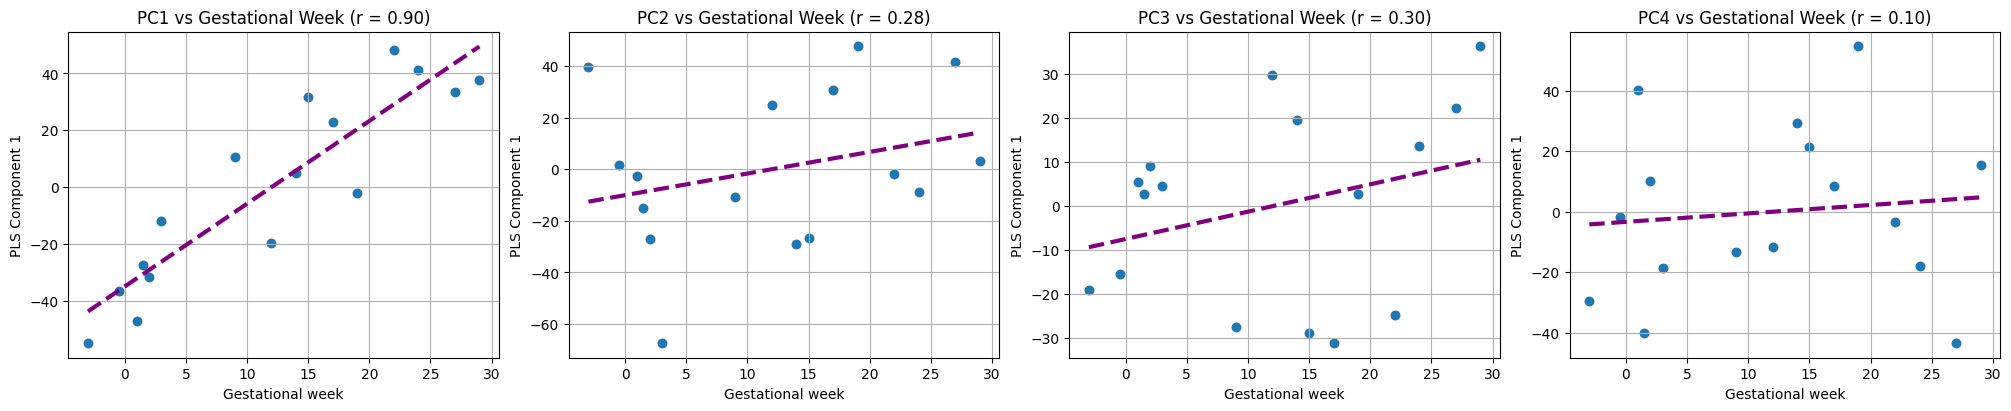

In [79]:
# for structure_id, structure_name in structure_key.items():
# figure, axs = plt.subplots(1, 4)
n_comps = 4
n_sessions = 16
fig, axes = plt.subplots(1, n_comps, figsize=(5 * n_comps, 4), constrained_layout=True)

for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for session_id in range(n_sessions): #mesh in aligned_meshes.values():
        mesh = aligned_meshes[session_id]
        all_mesh_points.append(mesh.points)
    weeks = weeks[0:n_sessions]
    # print(len(all_mesh_points[0]))
    # print(np.array(all_mesh_points).shape)
    # X, meshes_ = dataset_pipe((X_base, aligned_meshes))
    verts_reshaped = np.array(all_mesh_points).reshape(len(all_mesh_points), 3 * len(all_mesh_points[0]))
    X = StandardScaler().fit_transform(verts_reshaped)
    y = StandardScaler().fit_transform(weeks.reshape(-1,1))

    pls = PLSRegression(n_components=n_comps)
    pls.fit(X, y)

    pls_scores = pls.x_scores_
    r2_total = pls.score(X, y)
    print(f"Global R2 {r2_total:.3f}")

    for comp in range(n_comps):
        ax = axes[comp]
        corr, pval = pearsonr(pls_scores[:,comp], weeks)

        # Linear regression
        x_lr = weeks.reshape(-1, 1)
        # print("X LINREG",x_lr)
        y_lr = pls_scores[:, comp]
        reg = LinearRegression().fit(x_lr, y_lr)
        y_pred = reg.predict(x_lr)
        r2 = r2_score(y_lr, y_pred)
    
        print(f"Component {comp+1}: r = {corr:.3f}, p = {pval:.7f}, R² = {r2:.3f}, p = {pval:.7f}")
    
        # Scatter
        ax.scatter(weeks, y_lr, label='Data', color='gray', alpha=0.6)
    
        # Regression line
        x_pred = np.linspace(x_lr.min(), x_lr.max(), 100).reshape(-1, 1)
        y_line = reg.predict(x_pred)
        ax.plot(x_pred, y_line, color='purple', linestyle='--', label='Linear fit', linewidth=3)
    
        # print(f"Correlation between PC{comp+1} and gestational week: r = {corr:.3f}, p = {pval:.7f}")
        ax.scatter(weeks, pls_scores[:,comp])
        
        ax.set_xlabel("Gestational week")
        ax.set_ylabel("PLS Component 1")
        ax.set_title(f"PC{comp+1} vs Gestational Week (r = {corr:.2f})")
        ax.grid(True)
    plt.show()

Component 1: r = 0.836, p = 0.0000001, R² = 0.698, p = 0.0000001
Component 2: r = -0.348, p = 0.0749755, R² = 0.121, p = 0.0749755
Component 3: r = 0.318, p = 0.1064666, R² = 0.101, p = 0.1064666
Component 4: r = 0.218, p = 0.2745234, R² = 0.048, p = 0.2745234


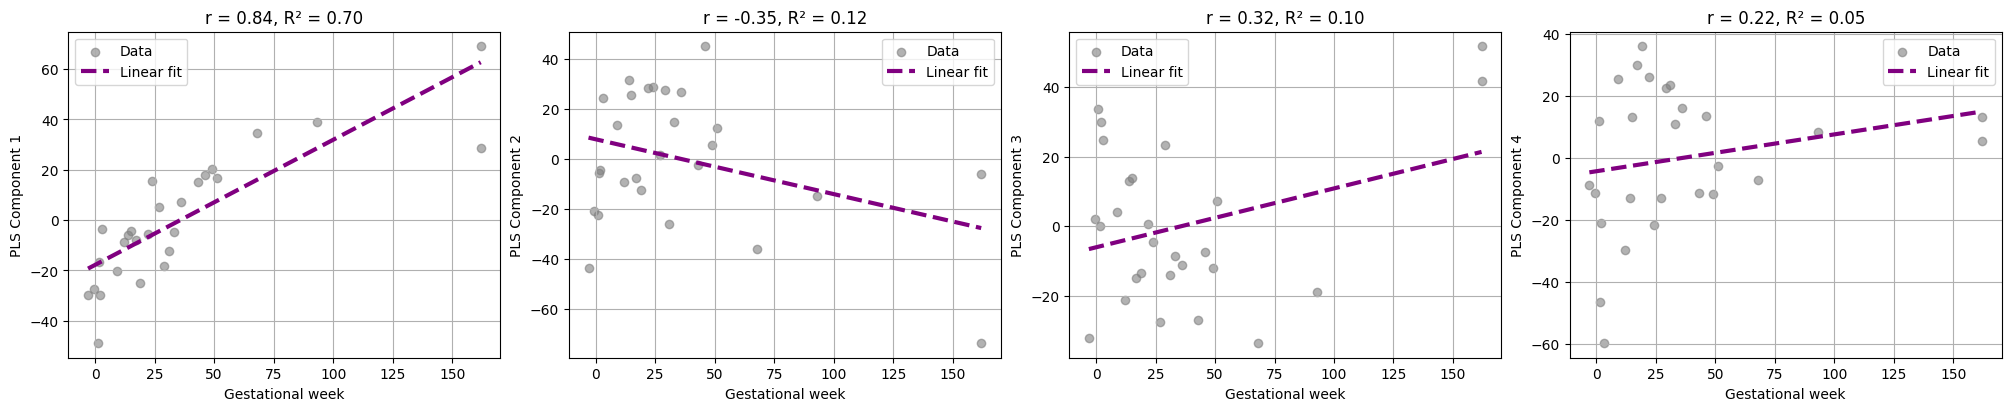

In [63]:
fig, axes = plt.subplots(1, n_comps, figsize=(5 * n_comps, 4), constrained_layout=True)

for comp in range(n_comps):
    ax = axes[comp]
    
    x = weeks.reshape(-1, 1)
    y = pls_scores[:, comp]
    
    # Correlation
    corr, pval = pearsonr(y, weeks)

    # Linear regression
    reg = LinearRegression().fit(x, y)
    y_pred = reg.predict(x)
    r2 = r2_score(y, y_pred)

    print(f"Component {comp+1}: r = {corr:.3f}, p = {pval:.7f}, R² = {r2:.3f}, p = {pval:.7f}")

    # Scatter
    ax.scatter(weeks, y, label='Data', color='gray', alpha=0.6)

    # Regression line
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_line = reg.predict(x_pred)
    ax.plot(x_pred, y_line, color='purple', linestyle='--', label='Linear fit', linewidth=3)

    ax.set_xlabel("Gestational week")
    ax.set_ylabel(f"PLS Component {comp + 1}")
    ax.set_title(f"r = {corr:.2f}, R² = {r2:.2f}")
    ax.grid(True)
    ax.legend()

plt.show()

In [31]:
all_meshes[17][0].faces

array([   3,    1,    8, ..., 2499, 2501, 2500], shape=(20000,))

In [81]:
import time
import logging
logging.getLogger().setLevel(logging.WARNING)

from scipy.spatial.distance import pdist

def show_deformation_animation_notebook(
    mean_shape, direction, faces,
    alpha_max=30.0, n_frames=60, n_loops=3, comp_id=0,
    title="PLS Component Deformation"
):

    alphas = np.concatenate([
        np.linspace(-alpha_max, alpha_max, n_frames),
        np.linspace(alpha_max, -alpha_max, n_frames)
    ])

    mesh = pv.PolyData(mean_shape.copy(), faces)
    displacement = np.linalg.norm(direction, axis=1)
    mesh["Displacement"] = displacement

    plotter = pv.Plotter(notebook=True, window_size=(600, 600))
    # plotter.show(jupyter_backend='trame', auto_close=False)
    plotter.add_mesh(mesh, scalars="Displacement", cmap="viridis")
    plotter.add_text(f"PLS Component {comp_id + 1} | α = 0.00", position="upper_edge", font_size=10)
    plotter.show(auto_close=False)
    # plotter.show(jupyter_backend='pythreejs', auto_close=False)

    for loop in range(n_loops):
        for alpha in alphas:
            new_points = mean_shape + alpha * direction
            mesh.points = new_points.reshape(-1, 3)

            displacement = np.linalg.norm(alpha * direction, axis=1)
            mesh["Displacement"] = displacement

            plotter.render()
            time.sleep(0.03)  # Adjust for frame rate

    plotter.close()


def show_deformation_animation_save_gif(
    mean_shape, direction, faces,
    alpha_max=3.0, n_frames=60, comp_id=0,
    gif_path="_images/deformation.gif", title="PLS Component Deformation"
):
    """
    Animate and save mesh deformation along a PLS component to a GIF.
    """
    alphas = np.linspace(-alpha_max, alpha_max, n_frames)

    mesh = pv.PolyData(mean_shape.copy(), faces)

    plotter = pv.Plotter(window_size=(800, 800))
    plotter.open_gif(gif_path)
    plotter.add_mesh(mesh, color='lightgray')
    # plotter.add_title("", position="upper_edge", font_size=12)
    plotter.reset_camera()

    for alpha in alphas:
        new_points = mean_shape + alpha * direction
        mesh.points = new_points.reshape(-1, 3)
        plotter.add_title(f"PLS Component {comp_id + 1} | α = {alpha:.2f}",font_size=12)
        plotter.reset_camera()
        plotter.write_frame()  # Save this frame to the GIF
        plotter.render()

    plotter.close()
    print(f"✅ GIF saved to: {gif_path}")


def show_deformation_animation(mean_shape, direction, faces, alpha_max=30.0, n_frames=60, comp_id=0, title="PLS Component Deformation"):

    alphas = np.linspace(-alpha_max, alpha_max, n_frames)

    mesh = pv.PolyData(mean_shape.copy(), faces)

    plotter = pv.Plotter(window_size=(800, 800))
    plotter.add_mesh(mesh, color='lightgray')
    # plotter.add_mesh(mesh, scalars='Displacement', cmap='viridis')
    text_id = plotter.add_text("", position="upper_edge", font_size=12)
    plotter.show(auto_close=False)

    for alpha in alphas:
        new_points = mean_shape + alpha * direction
        mesh.points = new_points.reshape(-1, 3)  # update mesh geometry
        # displacement = np.linalg.norm(alpha * direction, axis=1)
        # mesh['Displacement'] = displacement
        plotter.add_title(f"PLS Component {comp_id + 1} | α = {alpha:.2f}",font_size=12)
        plotter.render()
        time.sleep(0.05)

    plotter.close()

# def show_deformation(minus, mean, plus, title='PLS Component Deformation'):
#     p = pv.Plotter(shape=(1, 3), window_size=(1200, 400))
#     for i, (shape, label) in enumerate(zip(
#         [minus, mean, plus],
#         [f"-{alpha}×PC{comp_id+1}", "Mean", f"+{alpha}×PC{comp_id+1}"]
#     )):
#         poly = pv.PolyData(shape, first_mesh.faces)
#         p.subplot(0, i)
#         p.add_text(label, font_size=10)
#         p.add_mesh(poly, color='lightgray')
#         p.view_xy()
#     p.link_views()
#     p.show(title=title)

for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    first_mesh = all_meshes[structure_id][0]

    points = mesh.points
    diameter = pdist(points).max()
    
    print(f"Exact mesh diameter: {diameter}")
    faces = first_mesh.faces

    # Step 1: Get mean shape and component directions
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(verts_reshaped)
    
    mean_shape = scaler.mean_
    weights = pls.x_weights_  # shape: (n_features, n_components)
    
    # Step 2: Choose component and scale
    comp_id = 0  # 0-based index for component
    alpha = 3  # exaggeration factor for visualization
    
    direction = weights[:, comp_id]  # shape (n_vertices * 3,)
    
    # Mean ± alpha × component
    shape_plus = mean_shape + alpha * direction
    shape_minus = mean_shape - alpha * direction
    
    # Step 3: Reshape to (n_vertices, 3)
    shape_mean = mean_shape.reshape(-1, 3)
    shape_plus = shape_plus.reshape(-1, 3)
    shape_minus = shape_minus.reshape(-1, 3)
        
    # Step 4: Visualize in PyVista
    show_deformation_animation_save_gif(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)
    # show_deformation_animation(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)
    # show_deformation_animation_notebook(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0, n_loops=2)


    # show_deformation(shape_minus, shape_mean, shape_plus)


Exact mesh diameter: 42.653629276488296
✅ GIF saved to: _images/deformation.gif


In [82]:
import pyvista as pv
import numpy as np
from ipywidgets import interact, IntSlider

def interactive_pls_slider(
    mean_shape, direction, faces,
    alpha_max=30.0, n_frames=60, comp_id=0
):
    alphas = np.linspace(-alpha_max, alpha_max, n_frames)
    meshes = []

    max_disp = np.max(np.linalg.norm(alpha_max * direction, axis=1))
    scalar_range = (-max_disp, max_disp)

    # Precompute all deformed meshes
    for alpha in alphas:
        deformed = mean_shape + alpha * direction
        deformed = deformed.reshape(-1, 3)
        # displacement = np.linalg.norm(alpha * direction, axis=1)
        displacement = np.dot(direction, np.ones(3)) * alpha  # signed magnitude
        mesh = pv.PolyData(deformed, faces)
        mesh["Displacement"] = displacement
        meshes.append(mesh)

    # Create a plotter for Jupyter
    plotter = pv.Plotter(notebook=True)
    # actor = plotter.add_mesh(meshes[0], scalars="Displacement", cmap="coolwarm") # change to red-blue divergent color map
    # Add mesh with fixed colormap range
    actor = plotter.add_mesh(
        meshes[0],
        scalars="Displacement",
        cmap="coolwarm",
        clim=scalar_range
    )
    plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alphas[0]:.2f}", font_size=10)
    # text_actor = plotter.add_text(f"PLS Component {comp_id + 1} | alpha = {alphas[0]:.2f}", font_size=10)
    plotter.show(auto_close=False)

    # Slider function
    def update(frame_idx):
        mesh = meshes[frame_idx]
        actor.mapper.SetInputData(mesh)
        # text_actor.SetText(0, f"PLS Component {comp_id + 1} | alpha = {alphas[frame_idx]:.2f}")
        plotter.add_title(f"PLS Component {comp_id + 1} | alpha = {alphas[frame_idx]:.2f}", font_size=10)
        plotter.render()

    interact(update, frame_idx=IntSlider(min=0, max=n_frames - 1, step=1, value=0))


interactive_pls_slider(mean_shape.reshape(-1, 3), direction.reshape(-1, 3), faces, comp_id=0)


Widget(value='<iframe src="http://localhost:49260/index.html?ui=P_0x37a27bc90_12&reconnect=auto" class="pyvist…

interactive(children=(IntSlider(value=0, description='frame_idx', max=59), Output()), _dom_classes=('widget-in…

In [85]:
weeks

array([-3. , -0.5,  1. ,  1.5,  2. ,  3. ,  9. , 12. , 14. , 15. , 17. ,
       19. , 22. , 24. , 27. , 29. ])

In [68]:
all_meshes[17][

{0: PolyData (0x309ad0100)
   N Cells:    5000
   N Points:   2502
   N Strips:   0
   X Bounds:   1.388e+02, 1.640e+02
   Y Bounds:   1.309e+02, 1.542e+02
   Z Bounds:   1.105e+02, 1.496e+02
   N Arrays:   0,
 1: PolyData (0x309ab7e80)
   N Cells:    5000
   N Points:   2502
   N Strips:   0
   X Bounds:   1.390e+02, 1.642e+02
   Y Bounds:   1.308e+02, 1.542e+02
   Z Bounds:   1.104e+02, 1.497e+02
   N Arrays:   0,
 2: PolyData (0x309ab50c0)
   N Cells:    5000
   N Points:   2502
   N Strips:   0
   X Bounds:   1.388e+02, 1.643e+02
   Y Bounds:   1.307e+02, 1.544e+02
   Z Bounds:   1.104e+02, 1.498e+02
   N Arrays:   0,
 3: PolyData (0x309ab7a00)
   N Cells:    5000
   N Points:   2502
   N Strips:   0
   X Bounds:   1.391e+02, 1.641e+02
   Y Bounds:   1.306e+02, 1.543e+02
   Z Bounds:   1.105e+02, 1.498e+02
   N Arrays:   0,
 4: PolyData (0x309ab6ec0)
   N Cells:    5000
   N Points:   2502
   N Strips:   0
   X Bounds:   1.389e+02, 1.643e+02
   Y Bounds:   1.306e+02, 1.542e+02
   Z

In [67]:
for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for mesh in aligned_meshes.values():
        all_mesh_points.append(mesh.points)
    # print(len(all_mesh_points[0]))
    # print(np.array(all_mesh_points).shape)
    # X, meshes_ = dataset_pipe((X_base, aligned_meshes))
    verts_reshaped = np.array(all_mesh_points).reshape(len(all_mesh_points), 3 * len(all_mesh_points[0]))
    X = StandardScaler().fit_transform(verts_reshaped)
    y = StandardScaler().fit_transform(weeks.reshape(-1,1))

    pls = PLSRegression(n_components=n_comps)
    pls.fit(X, y)

    pls_scores = pls.x_scores_
    r2_total = pls.score(X, y)

    reg = LinearRegression().fit(y, pls_scores)
    
    week_to_predict = 31
    predicted_scores = reg.predict([[week_to_predict]])
    
    # Step 5: Reconstruct full mesh from predicted PLS scores
    predicted_mesh_flat = np.dot(predicted_scores, pls.x_loadings_.T) + pls.x_mean_
    predicted_mesh = predicted_mesh_flat.reshape(-1, 3)  # shape = (n_vertices, 3)


    print(f"Global R2 {r2_total:.3f}")


AttributeError: 'PLSRegression' object has no attribute 'x_mean_'

In [83]:
def train_pls_and_regression(mesh_list, weeks, n_components=4):
    """
    Trains a PLS model (mesh → week) and a regression model (week → PLS space).
    
    Parameters:
    - mesh_list: list of (n_vertices, 3) arrays
    - weeks: array of shape (n_subjects,)
    - n_components: number of PLS components
    
    Returns:
    - predict_mesh_at_week: function(week) → (n_vertices, 3)
    """
    # Flatten and standardize meshes
    X = np.array(mesh_list).reshape(len(mesh_list), -1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    y = weeks.reshape(-1, 1)

    # Fit PLS (mesh → week)
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, y)
    
    # PLS scores (latent shape)
    scores = pls.x_scores_

    # Fit week → scores regression
    reg = LinearRegression()
    reg.fit(y, scores)

    # Return a function to predict mesh at a given week
    def predict_mesh_at_week(target_week):
        scores_pred = reg.predict(np.array([[target_week]]))  # predict shape summary
        X_pred_scaled = np.dot(scores_pred, pls.x_loadings_.T)
        X_pred = scaler.inverse_transform(X_pred_scaled)
        return X_pred.reshape(-1, 3)  # return as (n_vertices, 3)

    return predict_mesh_at_week


In [ ]:
for structure_id, structure_name in [(17,'Left-Hippocampus')]:
    aligned_meshes = all_meshes[structure_id]
    all_mesh_points = []
    for mesh in aligned_meshes.values():
        all_mesh_points.append(mesh.points)

# Step 1: Train the model
predict_mesh = train_pls_and_regression(mesh_list=all_mesh_points, weeks=weeks, n_components=4)

# Step 2: Predict a mesh
mesh_30w = predict_mesh(30)   # mesh at 30 weeks
mesh_20w = predict_mesh(20)   # mesh at 20 weeks